In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import numpy as np
from torchvision import transforms
import random
import os

In [3]:
class n_net(nn.Module):
    def __init__(self):
        super(n_net,self).__init__()
        self.n1 = nn.Linear(784,100)
        self.relu = nn.ReLU()
        self.n2 = nn.Linear(100,100)
        self.n3 = nn.Linear(100,10)
    def forward(self,x):
        x1 = self.n1(x)
        x2 = self.relu(x1)
        x3 = self.n2(x2)
        x4 = self.relu(x3)
        x5 = self.n3(x4)
        return x5

In [4]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [5]:
DOWNLOAD_ROOT = 'MNIST_data/'

dataset_1 = datasets.MNIST(root=DOWNLOAD_ROOT,train=True,transform=transforms.ToTensor(),download=True)
dataset_2 = datasets.MNIST(root=DOWNLOAD_ROOT,train=False,transform=transforms.ToTensor(),download=True)


In [6]:
BATCH_SIZE = 128
dataset_1_loader = DataLoader(dataset_1, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
dataset_2_loader = DataLoader(dataset_2, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)

In [7]:
LOAD = True
LEARNING_RATE = 0.01
SEED = 7777
torch.manual_seed(SEED)
if device == 'cuda':
    torch.cuda.manual_seed_all(SEED)
model = n_net()
model.zero_grad()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE)
TOTAL_BATCH = len(dataset_1_loader)
EPOCHS = 1000
loss_list = []
accuracy_list = []
epoch = 0

In [8]:
PATH = os.path.join("Saves","pretrained_model.pt")
SAVE_INTERVAL = 5
if LOAD:
    check = torch.load(PATH)
    model.load_state_dict(check["model"])
    epoch = check["epoch"]
    accuracy_list = check["accuracy list"]
    loss_list = check["loss list"]
    optimizer.load_state_dict(check["optimizer"])

In [9]:
while epoch < EPOCHS:
    cost = 0
    for image, label in dataset_1_loader:
        image = image.reshape(BATCH_SIZE,784)
        optimizer.zero_grad()
        predicted = model.forward(image)
        loss = loss_function(predicted,label)
        loss.backward()
        optimizer.step()
        cost+=loss
    with torch.no_grad():
        total = 0
        correct = 0
        for image, label in dataset_2_loader:
            image = image.reshape(BATCH_SIZE,784)
            out = model(image)
            _,predict = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predict==label).sum()
    average_cost = cost/TOTAL_BATCH
    accuracy = 100*correct/total
    loss_list.append(average_cost.detach().numpy())
    accuracy_list.append(accuracy)
    epoch+=1
    print("epoch : {} | loss : {:.6f}" .format(epoch, average_cost))
    print("Accuracy : {:.2f}".format(accuracy))
    print("---------------------")
    if epoch%5 ==0:
        torch.save({"epoch":epoch,"loss list":loss_list,"accuracy list":accuracy_list,"model":model.state_dict(),"optimizer":optimizer.state_dict()},PATH)


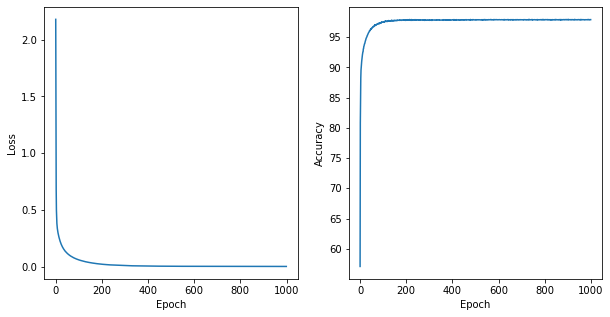

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(np.arange(0,EPOCHS),loss_list)
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(np.arange(0,EPOCHS), accuracy_list)
plt.show()

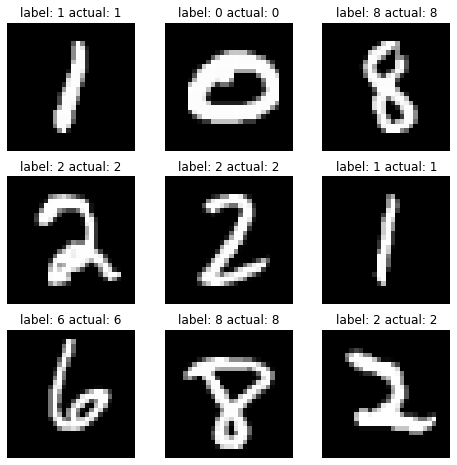

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_2), size=(1,)).item()
    img, label = dataset_2[sample_idx]
    image = img.reshape(1,784)
    figure.add_subplot(rows, cols, i)
    out = model(image)
    _,predict = torch.max(out.data, 1)
    plt.title("label: {} actual: {}".format(label,predict.item()))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()